In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table, unique
import astropy.units as u

In [2]:
import matplotlib as mpl
mpl.rcParams['axes.linewidth'] = 1.3 #set the value globally
mpl.rcParams['font.size'] = 12
mpl.rcParams['figure.figsize'] = (8.0, 6.0)

In [3]:
table = Table.read('../scripts/kepler_dr3_4arcsec.fits')

In [4]:
#table[np.isin(table['kepid'], kepids[np.array(n_matches) > 1])]

In [5]:
table['abs_gmag'] = table['phot_g_mean_mag'] + \
                            5.*(np.log10(table['parallax']/1.e3) + 1.)
table['abs_gmag'].unit = u.mag

/Users/mbedell/opt/miniconda3/envs/gr8stars/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  


#### test different ways of choosing the best match:

In [6]:
table['mag_diff'] = table['phot_g_mean_mag'] - table['kepmag']

In [7]:
table.sort(['kepid','kepler_gaia_ang_dist'])
best_match_dist = unique(table, keys='kepid', keep='first')
table.sort(['kepid','mag_diff'])
best_match_mag = unique(table, keys='kepid', keep='first')

In [8]:
diff_rows = np.where(best_match_dist['source_id'] != best_match_mag['source_id'])[0]
len(diff_rows)

1451

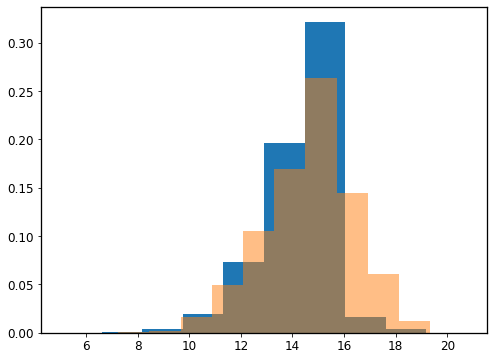

In [9]:
# are the ambiguous matches systematically fainter stars?
plt.hist(best_match_dist['kepmag'], density=True)
plt.hist(best_match_dist[diff_rows]['kepmag'], density=True, alpha=0.5);

In [10]:
assert np.all(best_match_dist['kepid'] == best_match_mag['kepid']) # check for ordering bugs

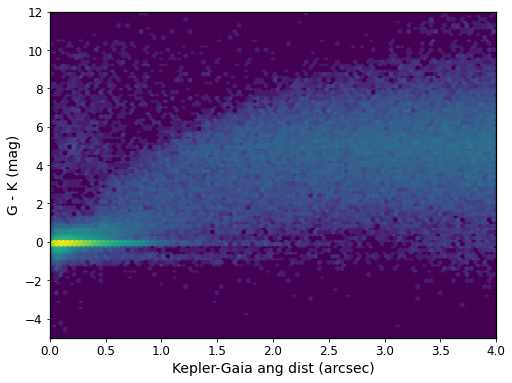

In [11]:
mask = np.isfinite(table['mag_diff'])
plt.hexbin(table['kepler_gaia_ang_dist'][mask], table['mag_diff'][mask], bins='log')
plt.xlim(0,4)
plt.ylim(-5,12)
plt.xlabel('Kepler-Gaia ang dist (arcsec)', fontsize=14)
plt.ylabel('G - K (mag)', fontsize=14);

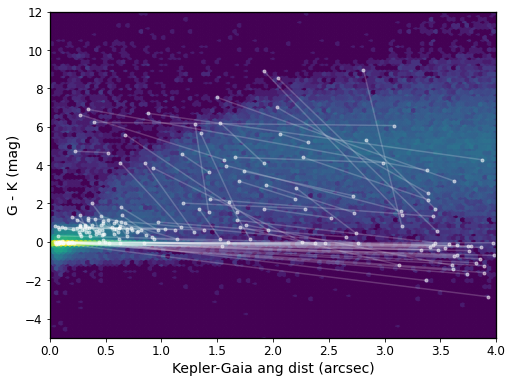

In [12]:
mask = np.isfinite(table['mag_diff'])
plt.hexbin(table['kepler_gaia_ang_dist'][mask], table['mag_diff'][mask], bins='log')
plt.xlim(0,4)
plt.ylim(-5,12)
plt.xlabel('Kepler-Gaia ang dist (arcsec)', fontsize=14)
plt.ylabel('G - K (mag)', fontsize=14)

for i in diff_rows[0:100]:    
    bestdist_dist, bestdist_mag = best_match_dist['kepler_gaia_ang_dist'][i], best_match_dist['mag_diff'][i]
    bestmag_dist, bestmag_mag = best_match_mag['kepler_gaia_ang_dist'][i], best_match_mag['mag_diff'][i]
    plt.plot(bestmag_dist, bestmag_mag, 'w.', alpha=0.5)
    plt.plot(bestdist_dist, bestdist_mag, 'w.', alpha=0.5)
    plt.plot((bestmag_dist,bestdist_dist), (bestmag_mag,bestdist_mag), 'w', alpha=0.2)

/Users/mbedell/opt/miniconda3/envs/gr8stars/lib/python3.7/site-packages/numpy/core/_asarray.py:171: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order, subok=True)


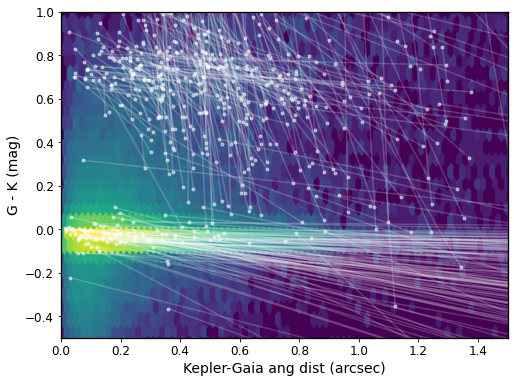

In [13]:
mask = np.isfinite(table['mag_diff'])
mask = mask & (table['kepler_gaia_ang_dist'] < 2.)
mask = mask & (table['mag_diff'] < 1.)
plt.hexbin(table['kepler_gaia_ang_dist'][mask], table['mag_diff'][mask], bins='log')
plt.xlabel('Kepler-Gaia ang dist (arcsec)', fontsize=14)
plt.ylabel('G - K (mag)', fontsize=14)
plt.ylim([-0.5,1])
plt.xlim([0,1.5])

for i in diff_rows[0:500]:    
    bestdist_dist, bestdist_mag = best_match_dist['kepler_gaia_ang_dist'][i], best_match_dist['mag_diff'][i]
    bestmag_dist, bestmag_mag = best_match_mag['kepler_gaia_ang_dist'][i], best_match_mag['mag_diff'][i]
    plt.plot(bestmag_dist, bestmag_mag, 'w.', alpha=0.5)
    plt.plot(bestdist_dist, bestdist_mag, 'w.', alpha=0.5)
    plt.plot((bestmag_dist,bestdist_dist), (bestmag_mag,bestdist_mag), 'w', alpha=0.2)

#### color-mag diagram of all the good matches:

In [14]:
# cut out all the multiple matches to be safe
good_matches = best_match_dist.copy()
good_matches.remove_rows(diff_rows)

In [15]:
# require that the magnitude difference is < 2 and the ang dist is < 1
mask = (np.abs(good_matches['mag_diff']) <= 2)
mag_trimmed_matches = good_matches[~mask].copy()

mask2 = (good_matches['kepler_gaia_ang_dist'] <= 1.*u.arcsec)
dist_trimmed_matches = good_matches[~mask2].copy()

good_matches = good_matches[(mask & mask2)]

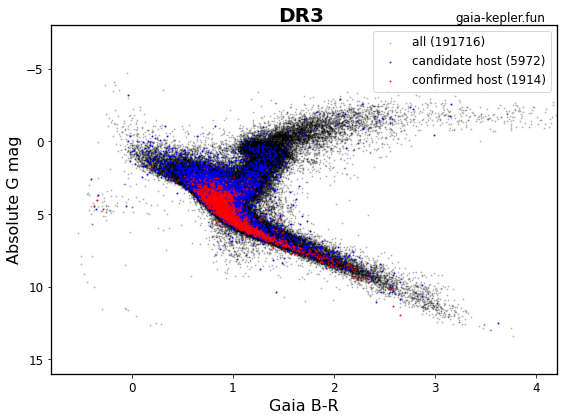

In [16]:
fig,ax = plt.subplots(1,1,figsize=(8,6))
filter = (good_matches['phot_g_mean_mag'] <= 18.) & (good_matches['parallax'] > 0.1)
ax.scatter(good_matches['bp_rp'][filter], good_matches['abs_gmag'][filter], alpha=0.2, color='k', s=1,
           label='all ({0})'.format(np.sum(filter)))
filter2 = (good_matches['planet?'] == 'cand') & filter
ax.scatter(good_matches['bp_rp'][filter2], good_matches['abs_gmag'][filter2], alpha=0.7, s=1, color='b',
           label='candidate host ({0})'.format(np.sum(filter2)))
filter2 = (good_matches['planet?'] == 'conf') & filter
ax.scatter(good_matches['bp_rp'][filter2], good_matches['abs_gmag'][filter2], alpha=0.7, s=1, color='r',
           label='confirmed host ({0})'.format(np.sum(filter2)))
ax.set_xlabel('Gaia B-R', fontsize=16)
ax.set_ylabel('Absolute G mag', fontsize=16)
ax.set_ylim([16,-8])
ax.set_xlim([-0.8,4.2])
ax.text(0.8,1.01,'gaia-kepler.fun', transform=plt.gca().transAxes)
ax.text(0.45,1.01,'DR3', transform=plt.gca().transAxes, fontweight='bold', fontsize=20)
ax.legend(loc='upper right')
plt.tight_layout()
#plt.savefig('../img/colormag_kepler_dr3.png', dpi=200)

In [17]:
good_matches.write('../scripts/kepler_dr3_good.fits', format='fits', overwrite=True)

In [30]:
len(good_matches)

195513

In [32]:
len(np.unique(table['kepid'])) - len(good_matches)

4234

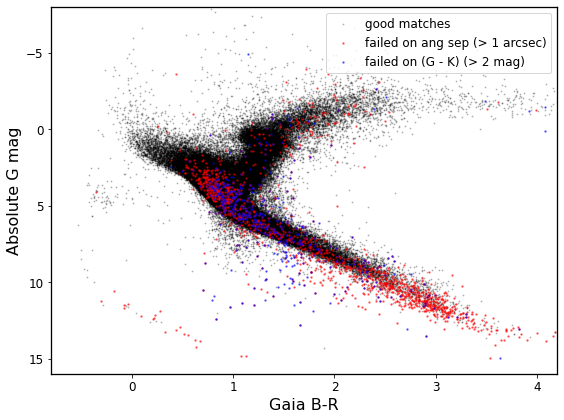

In [19]:
fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.scatter(good_matches['bp_rp'], good_matches['abs_gmag'], alpha=0.2, color='k', s=1,
          label='good matches')
ax.scatter(dist_trimmed_matches['bp_rp'], dist_trimmed_matches['abs_gmag'], alpha=0.5, color='r', 
           s=2, label='failed on ang sep (> 1 arcsec)')
ax.scatter(mag_trimmed_matches['bp_rp'], mag_trimmed_matches['abs_gmag'], alpha=0.5, color='b', 
           s=2, label='failed on (G - K) (> 2 mag)')

ax.set_xlabel('Gaia B-R', fontsize=16)
ax.set_ylabel('Absolute G mag', fontsize=16)
ax.set_ylim([16,-8])
ax.set_xlim([-0.8,4.2])
ax.legend(loc='upper right')
plt.tight_layout()

In [33]:
print("{0} KICs with RVS spectra".format(np.sum(good_matches['has_rvs'])))
print("{0} KICs with XP sampled spectra".format(np.sum(good_matches['has_xp_sampled'])))
print("{0} KICs with XP continuous spectra".format(np.sum(good_matches['has_xp_continuous'])))

12675 KICs with RVS spectra
119009 KICs with XP sampled spectra
194758 KICs with XP continuous spectra


#### check that my PM propagation is making the matches better:

In [22]:
table = Table.read('../scripts/kepler_dr3_4arcsec.fits')

In [23]:
pm_threshold = 0.05 #* u.arcsec/u.yr -- at/above this, apply PM corrections
fast_mask = np.sqrt(table['pmra'].to(u.arcsec/u.yr).value**2 
                        + table['pmdec'].to(u.arcsec/u.yr).value**2) >= pm_threshold

In [24]:
fast_table = table[fast_mask]
len(fast_table)

2573

In [25]:
gaia_matches_file = '../data/kepler_30arcsec_gaia.fits'
table_orig = Table.read(gaia_matches_file)
fast_table['angdist'] = 0. * u.arcsec
fast_table['n_matches'] = 0.
for i,f in enumerate(fast_table):
    fast_table['n_matches'][i] = np.sum(table['kepid'] == f['kepid'])
    orig_mask = (table_orig['source_id'] == f['source_id']) & (table_orig['kepid'] == f['kepid'])
    fast_table['angdist'][i] = (table_orig['angdist'][orig_mask]*u.degree).to(u.arcsec).value

In [31]:
#fast_table['kepid','pmra','pmra_error','pmdec','pmdec_error','angdist','kepler_gaia_ang_dist','n_matches']

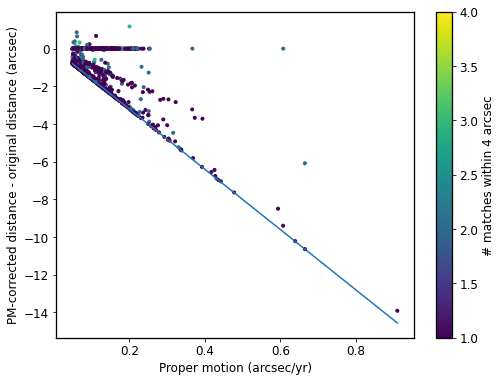

In [27]:
pm = np.sqrt(fast_table['pmra'].to(u.arcsec/u.yr).value**2 
                        + fast_table['pmdec'].to(u.arcsec/u.yr).value**2)
plt.scatter(pm, fast_table['kepler_gaia_ang_dist'] - fast_table['angdist'], marker='.', 
             c=fast_table['n_matches'])
plt.colorbar(label='# matches within 4 arcsec')
pms = np.linspace(pm.min(), pm.max(), 10)
plt.plot(pms, -pms*16)
plt.xlabel('Proper motion (arcsec/yr)')
plt.ylabel('PM-corrected distance - original distance (arcsec)');

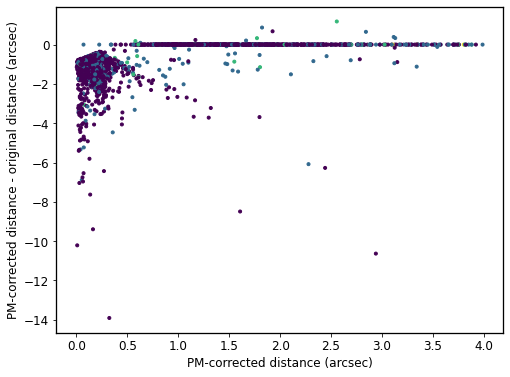

In [28]:
plt.scatter(fast_table['kepler_gaia_ang_dist'], fast_table['kepler_gaia_ang_dist'] - fast_table['angdist'], marker='.', 
             c=fast_table['n_matches'])
plt.xlabel('PM-corrected distance (arcsec)')
plt.ylabel('PM-corrected distance - original distance (arcsec)');

##### takeaways: 
in general the PM correction makes the angular separation smaller not larger, and for the ones where it does have a significant effect they then to end up at a small angular separation (i.e. good match) in the end.